# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.stats as bstats
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.scaler import CycleScaling
from osbad.model import ModelRunner

# Import dataset

## Define filepath

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Load only the training dataset
db_filepath = str(
    Path.cwd()
    .parent
    .joinpath("database","train_dataset_severson.db"))

## Get the cell inventory of the training dataset

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

# Get the cell index of training dataset
unique_cell_index_train = df_duckdb["cell_index"].unique()
print(f"Unique cell index: {unique_cell_index_train}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Unique cell index: ['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [5]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

## Drop true labels

* Drop true outlier labels (denoted as ``outlier``) from the dataframe and select only relevant features for ML:
  * ``cell_index``: The cell-ID for data and model versioning purposes;
  * ``cycle_index``: The cycle number of each cell;
  * ``discharge_capacity``: Discharge capacity of the cell;
  * ``voltage``: Discharge voltage of the cell.

In [6]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************


## Plot cycling data without labels

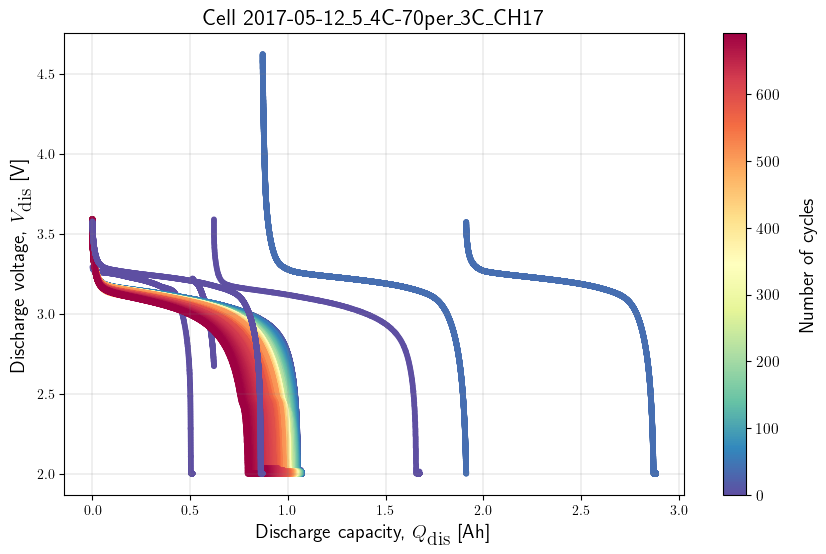

In [7]:
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels)

plt.show()

# Statistical Feature Transformation

To help with the separation of abnormal cycles from normal cycles, we propose a new statistical feature transformation method using the median and IQR of the input features:  

$$
\begin{equation}
x_\textrm{scaled} = x_i - \left[\frac{\textrm{median}(X)^{2}}{\textrm{IQR}(X)}\right],
\end{equation} 
$$

where the IQR can be calculated from the third ($75^\textrm{th}$ percentile) and first quartile ($25^\textrm{th}$ percentile) of the input vector ($\textrm{IQR}(X) = Q_3(X) - Q_1(X)$). Here, we use $\textrm{median}(X)^2$ to preserve the physical unit of the original feature after feature transformation. Feature scaling is implemented on both the capacity and voltage data.

## Capacity scaling

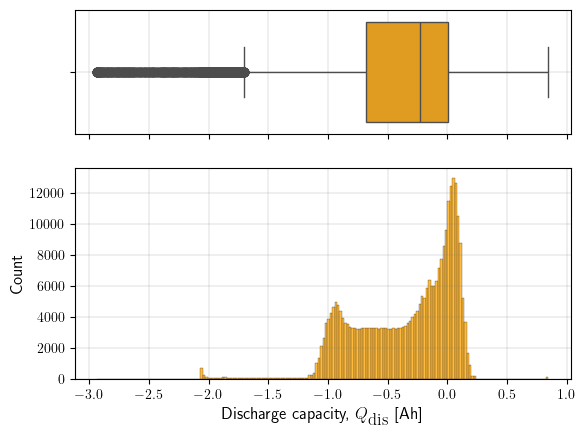

count    313326.000000
mean         -0.349626
std           0.414280
min          -2.933561
25%          -0.677412
50%          -0.226724
75%           0.005721
max           0.844670
Name: scaled_discharge_capacity, dtype: float64
**********************************************************************


0        -0.828787
1        -0.827432
2        -0.825870
3        -0.824306
4        -0.824306
            ...   
301553   -0.145985
301554   -0.145915
301555   -0.145915
301556   -0.145867
301557   -0.145867
Name: scaled_discharge_capacity, Length: 313326, dtype: float64

In [8]:
# Instantiate the CycleScaling class
scaler = CycleScaling(
    df_selected_cell=df_selected_cell_without_labels)

# Implement median IQR scaling on the discharge capacity data
df_capacity_med_scaled = scaler.median_IQR_scaling(
    variable="discharge_capacity",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_capacity_med_scaled["scaled_discharge_capacity"])

ax_hist.set_xlabel(
    r"Discharge capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "cap_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_capacity_med_scaled["scaled_discharge_capacity"].describe())
print("*"*70)

df_capacity_med_scaled["scaled_discharge_capacity"]

## Voltage scaling

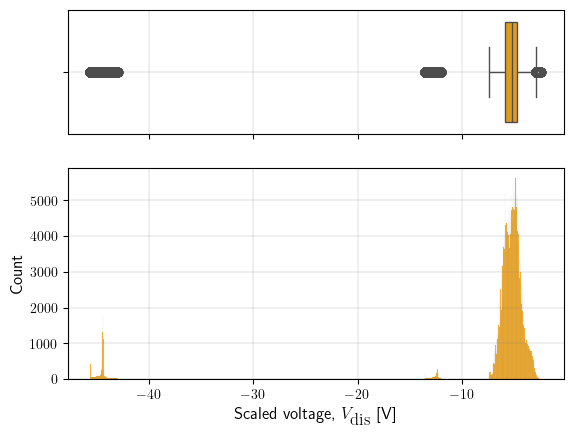

count    313326.000000
mean         -6.557421
std           7.159671
min         -45.644671
25%          -5.844655
50%          -5.215267
75%          -4.672330
max          -2.395836
Name: scaled_voltage, dtype: float64
**********************************************************************


0        -12.262836
1        -12.272870
2        -12.276842
3        -12.279593
4        -12.279593
            ...    
301553    -4.257652
301554    -4.257553
301555    -4.257553
301556    -4.257912
301557    -4.254364
Name: scaled_voltage, Length: 313326, dtype: float64

In [9]:
# Implement median IQR scaling on the discharge voltage data
df_voltage_med_scaled = scaler.median_IQR_scaling(
    variable="voltage",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_voltage_med_scaled["scaled_voltage"])

ax_hist.set_xlabel(
    r"Scaled voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "voltage_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_voltage_med_scaled["scaled_voltage"].describe())
print("*"*70)
df_voltage_med_scaled["scaled_voltage"]

## Scatter histogram

* Create scatterplot with histogram to display the distribution for x-axis and y-axis:
  * The salmon color corresponds to x-axis (``scaled_capacity``)
  * The grey color corresponds to y-axis (``scaled_voltage``)

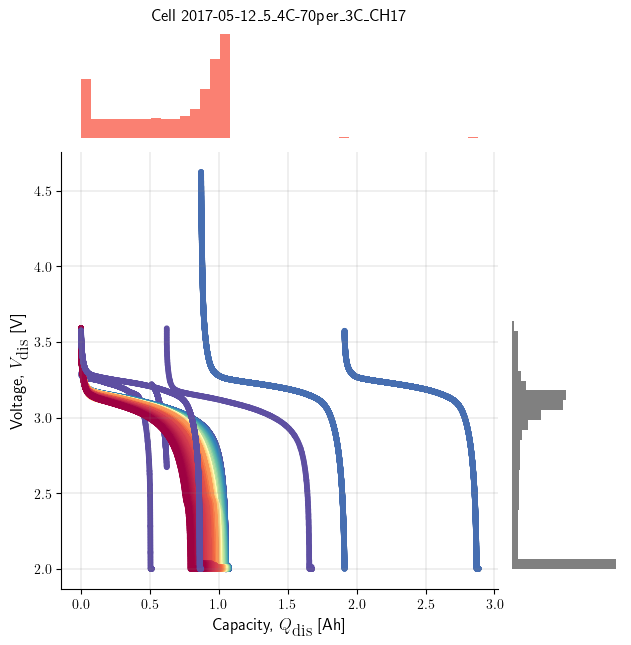

In [10]:
axplot = bviz.scatterhist(
    xseries=df_selected_cell_without_labels["discharge_capacity"],
    yseries=df_selected_cell_without_labels["voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"],
    selected_cell_label=selected_cell_label)

axplot.set_xlabel(
    r"Capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_no_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

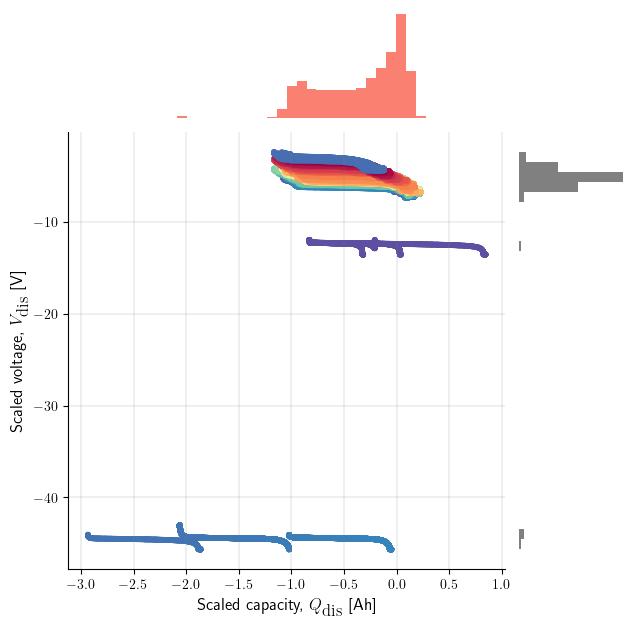

In [11]:
axplot = bviz.scatterhist(
    xseries=df_capacity_med_scaled["scaled_discharge_capacity"],
    yseries=df_voltage_med_scaled["scaled_voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"])

axplot.set_xlabel(
    r"Scaled capacity, $Q_\textrm{dis}$ [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Scaled voltage, $V_\textrm{dis}$ [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_with_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Physics-informed Feature Extraction

* As the anomalies in this dataset are collective due to a continuous series of abnormal voltage and current measurements, we can transform the collective anomalies of a given cycle into cycle-wise point anomalies.
* Use $\Delta V$ to detect any anomalies in the voltage data
* Because our focus is on detecting anomalous cycle (multiple collective outliers and not a single data point), we are only interested in the maximum $\Delta V$ per cycle.
* Drop the first and last 10 data points to exclude instantaneous voltage jump due to voltage relaxation at the beginning and at the end because of current interruptions. These are normal voltage behaviour, not considered as anomaly. 
* If continuous abnormal voltage and current measurements are recorded in a cycle, the specific cycle will be labelled as anomalous cycle.

$$
\begin{align}
\Delta Q_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(Q_{\textrm{scaled},{k+1}} - Q_{\textrm{scaled},{k}}), \\
\Delta V_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(V_{\textrm{scaled},{k+1}} - V_{\textrm{scaled},{k}}),
\end{align} 
$$

where $\Delta V_\textrm{scaled,max,cyc}$ is the maximum scaled voltage difference per cycle and $\Delta Q_\textrm{scaled,max,cyc}$ is the maximum scaled capacity difference per cycle. $k$ in these equations denote the index of each recorded data point.

* Don't use the natural index of the dataframe as the cycle index
* Create an additional column for the cycle_index so that we can keep track of the true cycle_index even after removing some anomalous cycle from the df

## Feature max dV

In [12]:
# maximum scaled voltage difference per cycle
df_max_dV = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_voltage_med_scaled,
    variable_name="scaled_voltage")

df_max_dV

,max_diff,log_max_diff,cycle_index
0,1.564151,0.447343,0.0
1,0.023727,-3.741163,1.0
2,0.022684,-3.786091,2.0
3,0.027899,-3.579172,3.0
4,0.026408,-3.634081,4.0
...,...,...,...
687,0.046420,-3.070023,687.0
688,0.051542,-2.965352,688.0
689,0.047776,-3.041228,689.0
690,0.046331,-3.071935,690.0


In [13]:
max_dV_feature_stats = bstats.calculate_feature_stats(
    df_max_dV["max_diff"],
    new_col_name="max_diff_dV")

max_dV_feature_stats

Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************


,max_diff_dV
max,2.6123
min,0.0227
mean,0.0411
std,0.1140


## Feature max dQ

In [14]:
# maximum scaled capacity difference per cycle
df_max_dQ = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_capacity_med_scaled,
    variable_name="scaled_discharge_capacity")

df_max_dQ

,max_diff,log_max_diff,cycle_index
0,0.006388,-5.053343,0.0
1,0.006338,-5.061258,1.0
2,0.006321,-5.063922,2.0
3,0.006259,-5.073756,3.0
4,0.006236,-5.077346,4.0
...,...,...,...
687,0.006236,-5.077391,687.0
688,0.006281,-5.070178,688.0
689,0.006243,-5.076238,689.0
690,0.006316,-5.064619,690.0


In [15]:
max_dQ_feature_stats = bstats.calculate_feature_stats(
    df_max_dQ["max_diff"],
    new_col_name="max_diff_dQ")

max_dQ_feature_stats

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************


,max_diff_dQ
max,0.0429
min,0.0062
mean,0.0064
std,0.0020


## Feature max dVdQ

In [16]:
df_max_dVdQ = scaler.calculate_max_feature_derivative_per_cycle(
    Xfeature=df_capacity_med_scaled["scaled_discharge_capacity"],
    Yfeature=df_voltage_med_scaled["scaled_voltage"],
    cycle_index=df_voltage_med_scaled["cycle_index"])

df_max_dVdQ

/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/scaler.py:262: RuntimeWarning: divide by zero encountered in divide
  feature_diff = numerator_feature_diff/denominator_feature_diff
/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/scaler.py:262: RuntimeWarning: invalid value encountered in divide
  feature_diff = numerator_feature_diff/denominator_feature_diff


,max_diff,log_max_diff,cycle_index
0,178932.163746,12.094762,0.0
1,10.879725,2.386901,1.0
2,9.355405,2.235954,2.0
3,7.779197,2.051453,3.0
4,9.119772,2.210445,4.0
...,...,...,...
687,8.897922,2.185818,687.0
688,7.007765,1.947019,688.0
689,7.087613,1.958349,689.0
690,7.316459,1.990126,690.0


In [17]:
max_dVdQ_feature_stats = bstats.calculate_feature_stats(
    df_max_dVdQ["max_diff"],
    new_col_name="max_diff_dVdQ")

max_dVdQ_feature_stats

Feature mean: 321.2474799595722
Feature max: 178932.16374587023
Feature min: 4.1214299224441175
Feature std: 6918.580867088767
**********************************************************************


,max_diff_dVdQ
max,178932.1637
min,4.1214
mean,321.2475
std,6918.5809


# Median Absolute Deviation (MAD)

$$
\begin{equation}
\textrm{MAD} = |F_\textrm{MAD}|\times \textrm{median}(|x_i - M|),
\end{equation} 
$$

* $x_i$ represents each data point in the extracted feature and
* $M$ is the median of the feature ($M = \textrm{median}(x)$).
* Then, the absolute difference from that median and median of those absolute deviations can be computed to calculate the MAD-score.
* $F_\textrm{MAD}$ is the MAD-factor:
   * If the underlying data distribution is Gaussian, then we can assume that $F_\textrm{MAD} = 1.4826$.
   * However, if one would like to relax the assumption about the normality of a feature distribution, then $F_\textrm{MAD}$ can be calculated from the reciprocal of the 75th-percentile of a standard distribution (a distribution with a mean of zero and a standard deviation of one).

# Feature: dV

## MAD on dV (flexible MAD-factor)

* The default MAD factor is ``None``, which means $F_\textrm{MAD}$ can be calculated from the reciprocal of the 75th-percentile of a standard distribution (a distribution with a mean of zero and a standard deviation of one).

In [18]:
# Access the dict of parameters for using 
# the MAD method
mad_param_dict = bstats.outlier_method["mad"].params
print(mad_param_dict)

{'mad_factor': None, 'mad_threshold': 3.0, 'ddof': 1}


In [19]:
(MAD_outlier_index_dV,
 MAD_min_limit_dV,
 MAD_max_limit_dV) = bstats.outlier_method["mad"].compute(
    df_max_dV["max_diff"], 
    **mad_param_dict)

print("*"*70)
print(f"MAD outlier index on dV: {MAD_outlier_index_dV}")
print(df_max_dV[df_max_dV["cycle_index"].isin(MAD_outlier_index_dV)])
print("*"*70)

Feature median: 0.034730899999999565
Feature z-score mean: 0.0
Feature z-score std. deviation: 1.0
MAD: 0.13799320920852684
MAD min limit: -0.37924872762558093
MAD max limit: 0.44871052762558006
**********************************************************************
MAD outlier index on dV: [ 0 40]
    max_diff  log_max_diff  cycle_index
0   1.564151      0.447343          0.0
40  2.612268      0.960219         40.0
**********************************************************************


### Bubble plot

Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 1.5641508000000002
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 2.612268400000005
----------------------------------------------------------------------


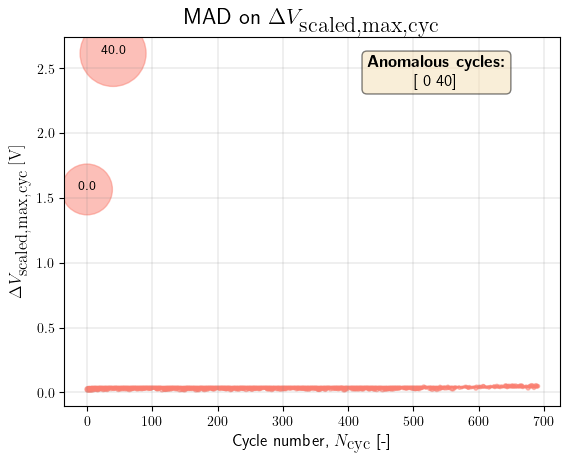

In [20]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dV = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dV["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dV["max_diff"],
    bubble_size=df_bubble_size_dV,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dV)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta V_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(r"MAD on $\Delta V_\textrm{scaled,max,cyc}$")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "mad_flex_dv_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

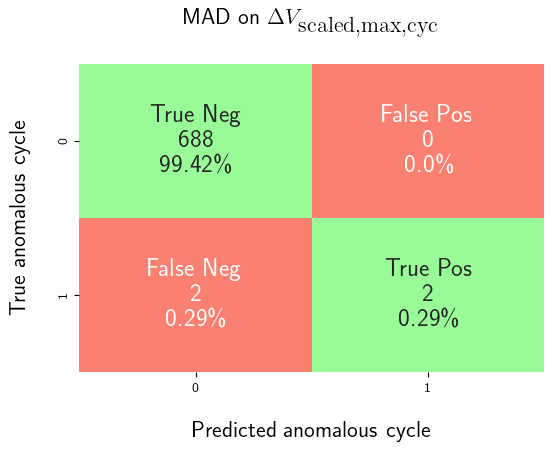

In [21]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dV = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dV)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dV["true_outlier"],
    y_pred=df_eval_outlier_mad_dV["pred_outlier"])

fig_title=(r"MAD on $\Delta V_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_flex_conf_matrix_dv_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## MAD on dV (MAD-factor = 1.4826)

* Let's also evaluate the result with ``MAD-factor = 1.4826``

In [22]:
# Create a copy of the default dict parameter
mad_param_dict_const = bstats.outlier_method["mad"].params.copy()
print(mad_param_dict_const)

# Update the dict value to be 1.4826
mad_param_dict_const["mad_factor"] = 1.4826
print(mad_param_dict_const)

{'mad_factor': None, 'mad_threshold': 3.0, 'ddof': 1}
{'mad_factor': 1.4826, 'mad_threshold': 3.0, 'ddof': 1}


In [23]:
(MAD_outlier_index_dV_const,
 MAD_min_limit_dV_const,
 MAD_max_limit_dV_const) = bstats.outlier_method["mad"].compute(
    df_max_dV["max_diff"], 
    **mad_param_dict_const)

print("*"*70)
print(f"MAD outlier index on dV: {MAD_outlier_index_dV_const}")
print(df_max_dV[df_max_dV["cycle_index"].isin(MAD_outlier_index_dV_const)])
print("*"*70)

Feature median: 0.034730899999999565
MAD: 0.005272496249999892
MAD min limit: 0.018913411249999887
MAD max limit: 0.05054838874999924
**********************************************************************
MAD outlier index on dV: [  0  40 665 681 688]
     max_diff  log_max_diff  cycle_index
0    1.564151      0.447343          0.0
40   2.612268      0.960219         40.0
665  0.050672     -2.982372        665.0
681  0.051587     -2.964484        681.0
688  0.051542     -2.965352        688.0
**********************************************************************


### Bubble plot

Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 1.5641508000000002
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 2.612268400000005
----------------------------------------------------------------------
Potential anomalous cycle: 665.0
x-position of the text: 665.0
y-position of the text: 0.05067249999999923
----------------------------------------------------------------------
Potential anomalous cycle: 681.0
x-position of the text: 681.0
y-position of the text: 0.051587100000000774
----------------------------------------------------------------------
Potential anomalous cycle: 688.0
x-position of the text: 688.0
y-position of the text: 0.0515

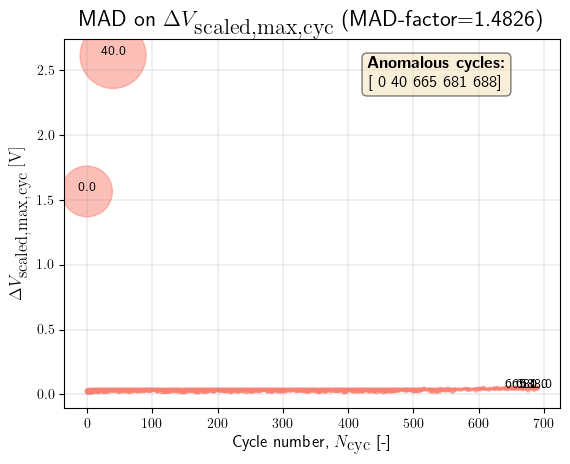

In [24]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dV = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dV["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dV["max_diff"],
    bubble_size=df_bubble_size_dV,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dV_const)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta V_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(r"MAD on $\Delta V_\textrm{scaled,max,cyc}$ (MAD-factor=1.4826) \newline")

axplot.set_title(
    fig_title,
    fontsize=16)


output_fig_filename = (
    "mad_const_dv_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

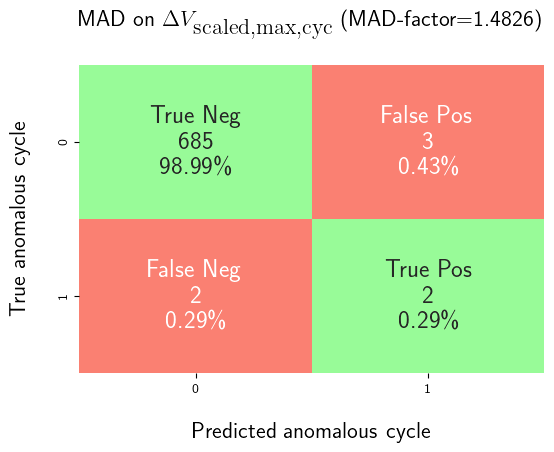

In [25]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dV = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dV_const)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dV["true_outlier"],
    y_pred=df_eval_outlier_mad_dV["pred_outlier"])

fig_title=(
    r"MAD on $\Delta V_\textrm{scaled,max,cyc}$ (MAD-factor=1.4826) \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_const_conf_matrix_dv_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature: dQ

## MAD on dQ (flexible MAD-factor)

In [26]:
(MAD_outlier_index_dQ,
 MAD_min_limit_dQ,
 MAD_max_limit_dQ) = bstats.outlier_method["mad"].compute(
    df_max_dQ["max_diff"], 
    **mad_param_dict)

print("*"*70)
print(f"MAD outlier index on dQ: {MAD_outlier_index_dQ}")
print(df_max_dQ[df_max_dQ["cycle_index"].isin(MAD_outlier_index_dQ)])
print("*"*70)

Feature median: 0.006289509999999998
Feature z-score mean: 0.0
Feature z-score std. deviation: 1.0
MAD: 0.0008305427477439969
MAD min limit: 0.0037978817567680075
MAD max limit: 0.00878113824323199
**********************************************************************
MAD outlier index on dQ: [147 148]
     max_diff  log_max_diff  cycle_index
147  0.042814     -3.150895        147.0
148  0.042899     -3.148905        148.0
**********************************************************************


### Bubble plot

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************
Potential anomalous cycle: 147.0
x-position of the text: 147.0
y-position of the text: 0.04281378999999996
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: 148.0
y-position of the text: 0.042899057000000074
----------------------------------------------------------------------


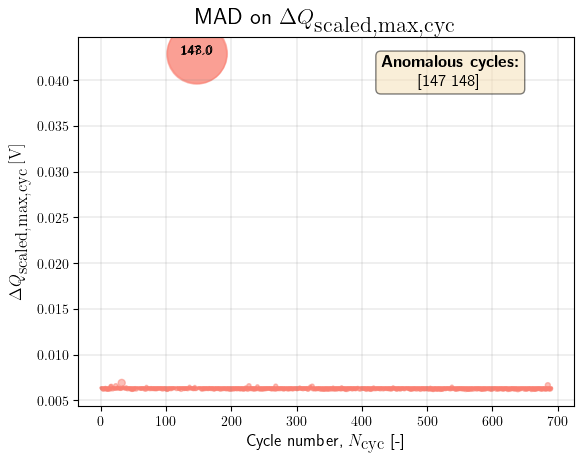

In [27]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dQ["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dQ["max_diff"],
    bubble_size=df_bubble_size_dQ,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dQ)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta Q_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(r"MAD on $\Delta Q_\textrm{scaled,max,cyc}$")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "mad_flex_dq_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

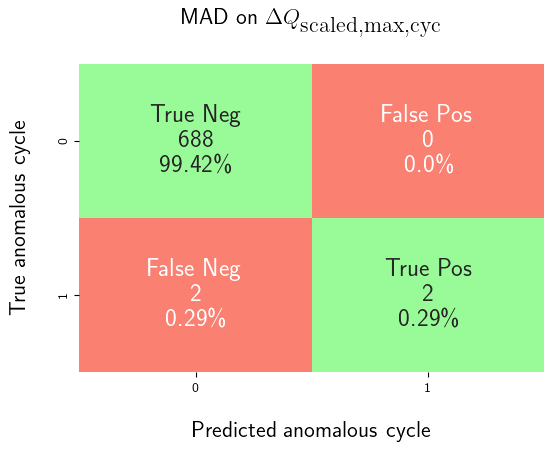

In [28]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dQ)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dQ["true_outlier"],
    y_pred=df_eval_outlier_mad_dQ["pred_outlier"])

fig_title=(r"MAD on $\Delta Q_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_flex_conf_matrix_dq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## MAD on dQ (MAD-factor = 1.4826)

* Let's also evaluate the result with ``MAD-factor = 1.4826``

In [29]:
(MAD_outlier_index_dQ_const,
 MAD_min_limit_dQ_const,
 MAD_max_limit_dQ_const) = bstats.outlier_method["mad"].compute(
    df_max_dQ["max_diff"], 
    **mad_param_dict_const)

print("*"*70)
print(f"MAD outlier index on dQ: {MAD_outlier_index_dQ_const}")
print(df_max_dQ[df_max_dQ["cycle_index"].isin(MAD_outlier_index_dQ_const)])
print("*"*70)

Feature median: 0.006289509999999998
MAD: 4.844395500005565e-05
MAD min limit: 0.006144178134999831
MAD max limit: 0.006434841865000165
**********************************************************************
MAD outlier index on dQ: [  7  15  16  23  26  32  34  39  70 136 144 147 148 222 227 240 268 304
 305 321 324 356 369 394 418 448 505 538 685]
     max_diff  log_max_diff  cycle_index
7    0.006440     -5.045193          7.0
15   0.006524     -5.032257         15.0
16   0.006556     -5.027451         16.0
23   0.006594     -5.021527         23.0
26   0.006467     -5.041082         26.0
32   0.006912     -4.974528         32.0
34   0.006456     -5.042714         34.0
39   0.006468     -5.040963         39.0
70   0.006490     -5.037430         70.0
136  0.006497     -5.036365        136.0
144  0.006485     -5.038316        144.0
147  0.042814     -3.150895        147.0
148  0.042899     -3.148905        148.0
222  0.006462     -5.041892        222.0
227  0.006590     -5.022164       

### Bubble plot

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************
Potential anomalous cycle: 7.0
x-position of the text: 7.0
y-position of the text: 0.0064402199999999965
----------------------------------------------------------------------
Potential anomalous cycle: 15.0
x-position of the text: 15.0
y-position of the text: 0.006524070000000104
----------------------------------------------------------------------
Potential anomalous cycle: 16.0
x-position of the text: 16.0
y-position of the text: 0.006555500000000047
----------------------------------------------------------------------
Potential anomalous cycle: 23.0
x-position of the text: 23.0
y-position of the text: 0.006594449999999918
----------------------------------------------------------------------
Potential anomalous cycle: 26.0
x-position of the text: 26.0
y-position of the text: 

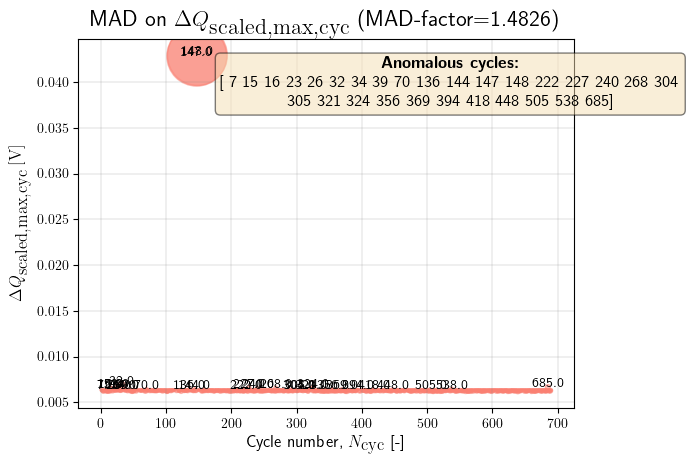

In [30]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dQ["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dQ["max_diff"],
    bubble_size=df_bubble_size_dQ,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dQ_const)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$\Delta Q_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(r"MAD on $\Delta Q_\textrm{scaled,max,cyc}$ (MAD-factor=1.4826) \newline")

axplot.set_title(
    fig_title,
    fontsize=16)


output_fig_filename = (
    "mad_const_dq_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

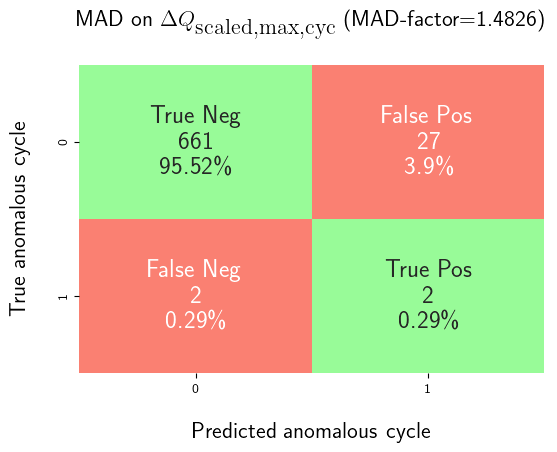

In [31]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dQ_const)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dQ["true_outlier"],
    y_pred=df_eval_outlier_mad_dQ["pred_outlier"])

fig_title=(
    r"MAD on $\Delta Q_\textrm{scaled,max,cyc}$ (MAD-factor=1.4826) \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_const_conf_matrix_dq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature: dVdQ

## MAD on log(dVdQ) (flexible MAD-factor)

* Due to the significant difference in the anomaly score between normal cycles and abnormal cycles for the feature $({dV}/{dQ})_\textrm{scaled,max,cyc}$ (see the bubble plot), natural logarithm is used in this comparison to minimize the variances.

In [48]:
(MAD_outlier_index_dVdQ,
 MAD_min_limit_dVdQ,
 MAD_max_limit_dVdQ) = bstats.outlier_method["mad"].compute(
    df_max_dVdQ["log_max_diff"], 
    **mad_param_dict)

print("*"*70)
print(f"MAD outlier index on dVdQ: {MAD_outlier_index_dVdQ}")
print(df_max_dVdQ[df_max_dVdQ["cycle_index"].isin(MAD_outlier_index_dVdQ)])
print("*"*70)

Feature median: 2.4804507281050907
Feature z-score mean: -0.0
Feature z-score std. deviation: 1.0
MAD: 0.9391858202352404
MAD min limit: -0.33710673260063073
MAD max limit: 5.298008188810812
**********************************************************************
MAD outlier index on dVdQ: [ 0 40]
         max_diff  log_max_diff  cycle_index
0   178932.163746     12.094762          0.0
40   33622.153846     10.422940         40.0
**********************************************************************


### Bubble plot

Feature mean: 321.2474799595722
Feature max: 178932.16374587023
Feature min: 4.1214299224441175
Feature std: 6918.580867088767
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 178932.16374587023
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 33622.15384614415
----------------------------------------------------------------------


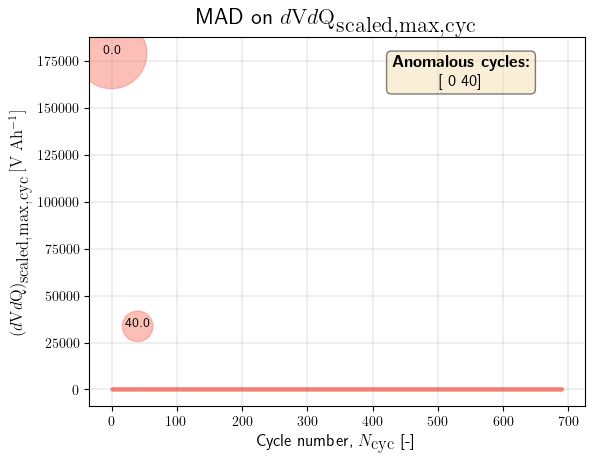

In [47]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dVdQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dVdQ["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dVdQ["max_diff"],
    bubble_size=df_bubble_size_dVdQ,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dVdQ)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$(d\textrm{V}d\textrm{Q})_\textrm{scaled,max,cyc}\;\textrm{[V Ah$^{-1}$]}$",
    fontsize=12)

fig_title=(r"MAD on $d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc}$ \newline")

axplot.set_title(
    fig_title,
    fontsize=16)

output_fig_filename = (
    "mad_flex_dvdq_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

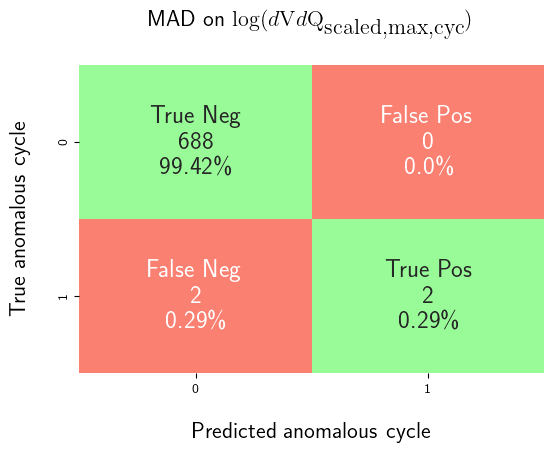

In [49]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dVdQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dVdQ)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dVdQ["true_outlier"],
    y_pred=df_eval_outlier_mad_dVdQ["pred_outlier"])

fig_title=(r"MAD on $\log(d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc})$ \newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_flex_conf_matrix_dvdq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## MAD on log(dVdQ) (MAD-factor = 1.4826)

* Let's also evaluate the result with ``MAD-factor = 1.4826``

In [52]:
(MAD_outlier_index_dVdQ_const,
 MAD_min_limit_dVdQ_const,
 MAD_max_limit_dVdQ_const) = bstats.outlier_method["mad"].compute(
    df_max_dVdQ["log_max_diff"], 
    **mad_param_dict_const)

print("*"*70)
print(f"MAD outlier index on dVdQ: {MAD_outlier_index_dVdQ_const}")
print(df_max_dVdQ[df_max_dVdQ["cycle_index"].isin(MAD_outlier_index_dVdQ_const)])
print("*"*70)

Feature median: 2.4804507281050907
MAD: 0.3620199591240475
MAD min limit: 1.394390850732948
MAD max limit: 3.5665106054772333
**********************************************************************
MAD outlier index on dVdQ: [  0  34  40 280 320 338 548 557 572 581 617 643 660 666 671 677 680 691]
          max_diff  log_max_diff  cycle_index
0    178932.163746     12.094762          0.0
34       36.818579      3.606003         34.0
40    33622.153846     10.422940         40.0
280      39.508087      3.676505        280.0
320      39.395457      3.673651        320.0
338      35.666291      3.574206        338.0
548      35.745237      3.576417        548.0
557      37.104062      3.613726        557.0
572      35.718238      3.575661        572.0
581      40.493875      3.701151        581.0
617      36.361974      3.593524        617.0
643      47.517896      3.861106        643.0
660      37.861078      3.633924        660.0
666      39.705270      3.681484        666.0
671      38.

### Bubble plot

Feature mean: 321.2474799595722
Feature max: 178932.16374587023
Feature min: 4.1214299224441175
Feature std: 6918.580867088767
**********************************************************************
Potential anomalous cycle: 0.0
x-position of the text: 0.0
y-position of the text: 178932.16374587023
----------------------------------------------------------------------
Potential anomalous cycle: 34.0
x-position of the text: 34.0
y-position of the text: 36.81857900759628
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 40.0
y-position of the text: 33622.15384614415
----------------------------------------------------------------------
Potential anomalous cycle: 280.0
x-position of the text: 280.0
y-position of the text: 39.50808743169386
----------------------------------------------------------------------
Potential anomalous cycle: 320.0
x-position of the text: 320.0
y-position of the text: 39.39545709594784


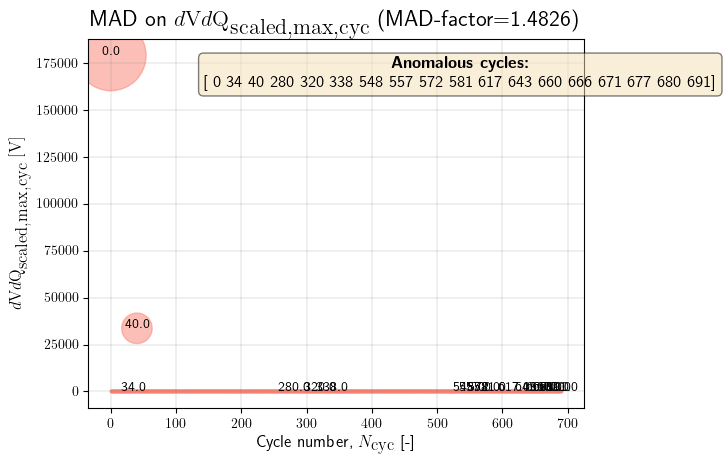

In [51]:
unique_cycle_count = (
    df_selected_cell_without_labels["cycle_index"]
    .unique())

df_bubble_size_dVdQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dVdQ["max_diff"])

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=unique_cycle_count,
    yseries=df_max_dVdQ["max_diff"],
    bubble_size=df_bubble_size_dVdQ,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=MAD_outlier_index_dVdQ_const)

axplot.set_xlabel(
    r"Cycle number, $N_\textrm{cyc}$ [-]",
    fontsize=12)

axplot.set_ylabel(
    r"$d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc}\;\textrm{[V]}$",
    fontsize=12)

fig_title=(
    r"MAD on $d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc}$ (MAD-factor=1.4826)\newline")

axplot.set_title(
    fig_title,
    fontsize=16)


output_fig_filename = (
    "mad_const_dvdq_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

### Confusion matrix

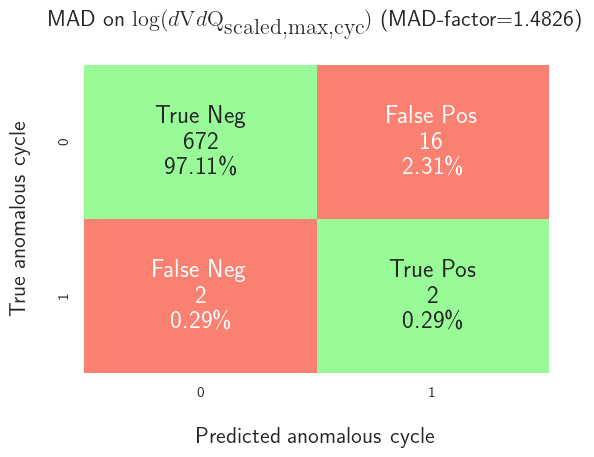

In [54]:
# Compare MAD predicted anomalies with true anomalies
df_eval_outlier_mad_dVdQ = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=MAD_outlier_index_dVdQ_const)

# Generate custom confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier_mad_dVdQ["true_outlier"],
    y_pred=df_eval_outlier_mad_dVdQ["pred_outlier"])

fig_title=(
    r"MAD on $\log(d\textrm{V}d\textrm{Q}_\textrm{scaled,max,cyc})$ (MAD-factor=1.4826)\newline")

axplot.set_title(
    fig_title 
    + "\n",
    fontsize=16)

output_fig_filename = (
    "mad_const_conf_matrix_dvdq_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Visualize potential anomalous cycles

## Multiple anomalous cycles

* Plot and annotate multiple potential outlier cycles.

Total subplot: 2
Total rows: 1
Total columns: 2
**********************************************************************
Plot outlier cycle: 0
Plot outlier cycle: 40


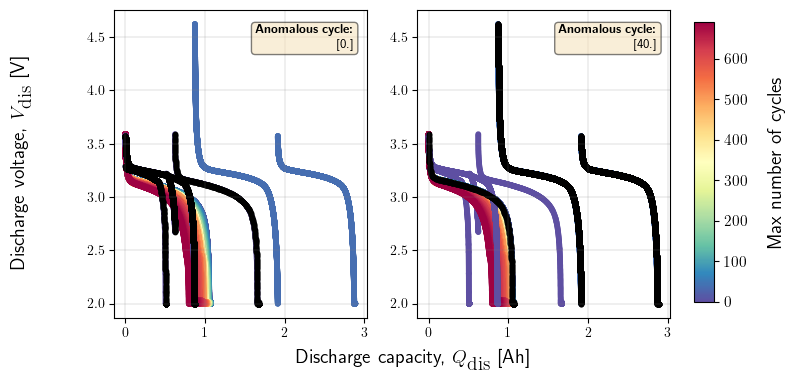

In [38]:
bviz.plot_multiple_outlier_cycles(
    df_selected_cell,
    potential_outlier_cycles= [0, 40],
    selected_cell_label=selected_cell_label)

## Single anomalous cycle

* Plot and annotate a single cycle as a potential outlier.

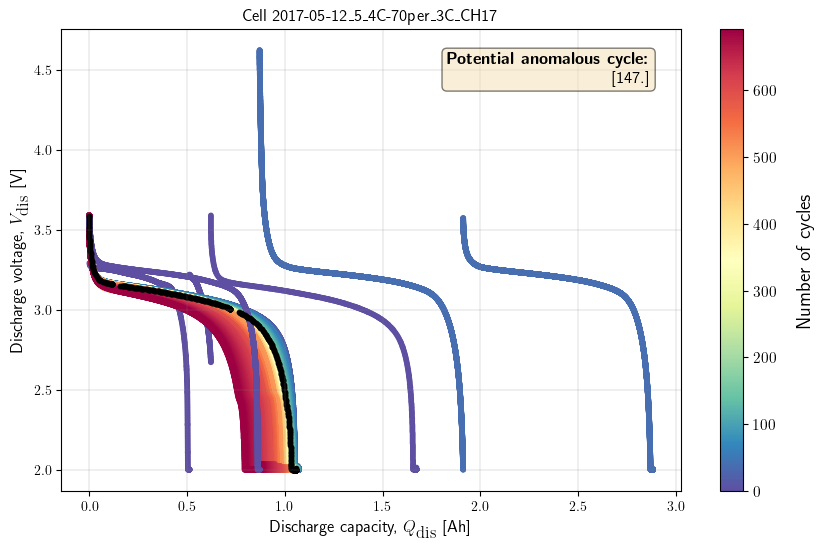

In [39]:
bviz.plot_single_outlier_cycle(
    df_selected_cell,
    selected_cycle_index=147,
    selected_cell_label=selected_cell_label)

# Plot cycle data with true outliers

In [40]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

    # Extract true outliers cycle index from benchmarking dataset
    true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
        df_selected_cell)
    print(f"True outlier cycle index:")
    print(true_outlier_cycle_index)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |

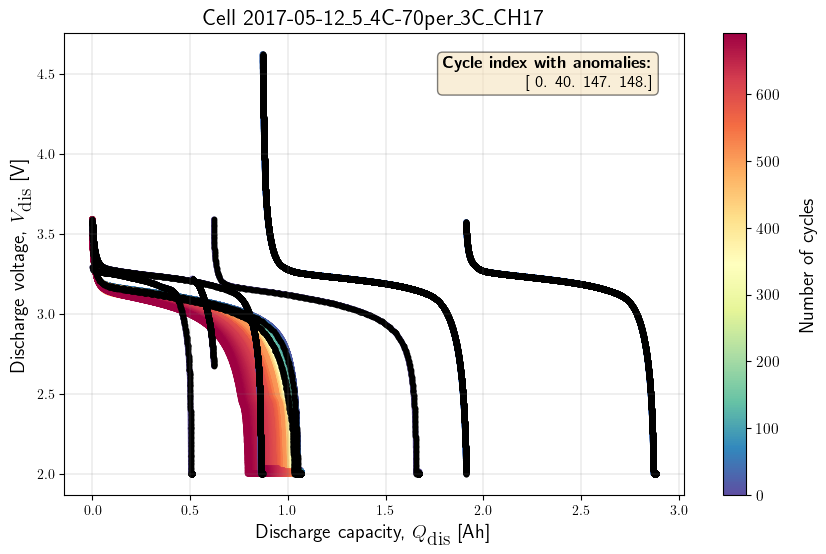

In [41]:
# Plot cell data with true anomalies
benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

plt.show()